# Тема 08. Попиксельная сегментация изображений.

На прошлом занятии мы ввели понятие попиксельной сегментации, когда нам надо определить, какие пиксели относятся к объекту, а какие нет (корректности ради такая задача называется instance segmentation, тогда как semantic segmentation предполагает, что пиксели относятся не к отдельным объектам, а к классам объектов, но мы не будем обращать на это внимание, называя задачу попиксельной сегментацией). 

Чтобы решить такую задачу нужно иметь примеры данных, в которых объектам уже сопоставлены пиксели, такие наборы данных существуют. Чтобы сопоставить пиксели объекту вводят так называемые **маски**. Маска, по-сути, это матрица такого-же размера, как и изображение (без каналов), каждый элемент которой принимает значение или 0 или 1 и показывает, пиксель этого изображения принадлежит или нет объекту. В масках, которые создаются после обучения эти величины лежат в диапазне от 0 до 1 и отображают степень уверенности, что пиксель принадлежит объекту. Имея такую маску для каждого объекта на изображении, пиксели, принадлежащие объекту, определяются наложением этой маски на изображение (поэлементное умножение). 

![img](https://drive.google.com/uc?id=194DGduBL4ke8cqRvNEk-6ywZR3yTbV5_)




Теперь задача заключается не только в определении класса и ограничивающего окна, но и в определении маски для объекта. Маска это просто матрица, поэтому добавляют еще один выход, который будет отвечать за маску объекта, а значит и в функции ошибки нужно будет учесть отклонение этой маски от действительной. Все это можно проделать. 

Несколько разных видов сетей могут решать задачу сегментации, та же YOLO, известная с прошлого занятия, при добавлении соответствующей части. Но сегодня мы поговорим о других сетях, точней семействе сетей типа R-CNN (Region-based Convolutional Neural Network), разные представители таких сетей могут решать и задачи локализации и детекции и сегментации.   



# Сети типа Region-based Convolutional Neural Network

Идея первоначальной **R-CNN** сети, которая могла решать задачу детекции, проста:
- на изображении выбирались некоторые окошки, которые возможно содержат объект (2000 штук) довольно сложным и долгим алгоритмом [selective search](https://ivi.fnwi.uva.nl/isis/publications/bibtexbrowser.php?key=UijlingsIJCV2013&bib=all.bib).
- содержимое этих окошек масштабировалось к одному размеру.
- для каждого окошка с помощью сверточной сети высчитывались вектора признаков (снятые с промежуточного слоя сети-классификатора, например, CaffeNet размером 4096).
- и для каждого такого окошка набор из SVM (линейных машин опроных векторов) проводил классифкацию.
- использовали линейную регрессию для уточнения положения ограничивающего окошка.

Такой подход оказался довольно долгим, и в версии **Fast-RCNN** решили, что давайте сначала пропустим изображение через сверточные слои, а затем уже будем вибирать окошки не на изображении, а на картах признаков с этих сверточных слоев (слой RoI pooling, region of interest). За одно объединили в одну сеть и классификацию и регрессию положения окошек. Конечно, и в функции ошибки сделали две части, одна отвечает за классификацию, вторая за регрессию (та же IoU).

![img](https://drive.google.com/uc?id=1MAxhnILIZrhEawtihUzyjyOLe_dsBK-P)

После выяснили, что самым долгим процессом является выбор окошек методом selective search.
В версии **Faster-RCNN** его решили заменить на нейронную сеть. Эта нейронная сеть (Region Proposal Network, RPN) является упрощенным классификатором с регрессией, которая расчитывает координаты окошек (на карте признаков), но имеет всего два класса: есть объект \ нет объекта и возвращает также уровень уверенности в том, что объект в окошке есть. Более точно, над картой признаков скользит окно, для каждого положения выбираются заданные окошки (anchor box), и для каждого из них сеть RPN рассчитывает уровень наличия объекта и уточнение в координаты окошка. 

## RPN:
![img](https://drive.google.com/uc?id=1VE7yr4dyXJnXjF6O3dB6Yx_1v1GXVG_C)


После заверщения работы RPN сети выбираются такие окошки, которые имеют высокий уровень уверенности и уже они проверяются частью Fast-RCNN (классификатор и регрессор).

Fast-RCNN часть и RPN очень похожи, имеют одинаковые промежуточные сверточные слои, поэтому обучается Faster-RCNN сеть попеременно:

- Инициализируется и обучается на определение регионов-кандидатов RPN-часть.
- С использованием предлагаемых RPN регионов заново обучается Fast-RCNN часть.
- Обученная сеть используется, чтобы инициализировать веса для RPN. Общие сверточные слои, фиксируются и производится донастройка только слоёв, специфичных для RPN.
- С зафиксированными сверточными слоями окончательно донастраивается Fast R-CNN.


## Faster-RCNN:
![img](https://drive.google.com/uc?id=1OTqrTqeTmlAuBsWpRQdRiWKW7LMKPeeG)

# Mask-RCNN

Наконец, чтобы можно было решать задачу сегментации в Faster-RCNN добавляют третий выход - маску. Точнее маски, для каждого возможного класса расчитывается своя маска, потом выбирается маска найденного класса.  Соответственно в функцию ошибки также добавляют  член, отвечающий за совпадение масок.

![img](https://drive.google.com/uc?id=1w-bJqb-go_gXzl2VjTfUlEBbDzifou9X)

При расчете признаков в выбранных окошках, из-за масштабирования, координаты признаков в карте могут быть не целыми. Чтобы сделать сеть еще точнее, что важно для масок, ведь там каждый пиксель важен, вместо округления, как в RoI pooling, используют интерполяцию по нескольким ближайшим значениям, назвали такой слой RoI allign:

![img](https://drive.google.com/uc?id=185EWS8PRhaOWSM-SRPZXLHT3sb7kp6iw)


Можно использовать различные уже предобученные или нет сети для снятия карт признаков.

Например Feature Pyramid Networks, в которых объединяются карты признаков с нижних и верхних слоев:
- изображение поступает на сверточные слои, которые уменьшают размер карт признаков в 2 раза.
- затем карты с малым размером масштабируются до большего в 2 раза размера и складываются с картами признаков с текущего уровня.

![img](https://drive.google.com/uc?id=17tX5dsbWQ9in07jpd74VqQUkhvmLIaBP)






# Сегментация с MaskRCNN
Уже обученную сеть MaskRCNN со всеми необходимыми функциями можно найти в библиотеке https://github.com/matterport/Mask_RCNN 

Давайте скачаем и установим эту библиотеку.

**%%shell** объявляет всю ячейку для работы с командной строкой.

Нам придется также откатить версию библиотеки h5py, отвечающей за сохранение и загрузку весов нейронных сетей до версии 2.10.0., после этого нажмите "Restart Runtime".

In [1]:
pip install 'h5py==2.10.0' --force-reinstall

  Using cached https://files.pythonhosted.org/packages/3f/c0/abde58b837e066bca19a3f7332d9d0493521d7dd6b48248451a9e3fe2214/h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a5/42/560d269f604d3e186a57c21a363e77e199358d054884e61b73e405dd217c/numpy-1.20.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d9/5a/e7c31adbe875f2abbb91bd84cf2dc52d792b5a01506781dbcf25c91daf11/six-1.16.0-py2.py3-none-any.whl
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.20.3 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll

In [1]:
%%shell
# клонируем (скачиваем) Mask_RCNN репозитарий
git clone https://github.com/matterport/Mask_RCNN
# переходим в директорию
cd Mask_RCNN
# и устанавливаем библиотеку уже имеющимся скриптом 
python setup.py install 

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Сегментация изображения с Mask R-CNN

Библиотека работает с tensorflow версии 1.x. Выберем ее. Подключим другие библиотеки.

In [3]:
import os
import sys
import random
import math
import numpy as np
import skimage.io # для чтения и записи изображений
import matplotlib
import matplotlib.pyplot as plt

# директория, куда клонировали библиотеку
ROOT_DIR = os.path.abspath("./Mask_RCNN/")

# Подключаем Mask RCNN
sys.path.append(ROOT_DIR)  # путь к локальной, клонированной версии
from mrcnn import utils # модуль с вспомогательными функциями
import mrcnn.model as modellib # основной модуль с функциями для MaskRCNN
from mrcnn import visualize # модуль для визуализации

# Подключаем библиотеку COCO с конфигурацией данных, на которых обучалась сеть
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # путь к локальной версии
import coco # подключаем

%matplotlib inline 

# Директория для сохранения отчетов и обученной модели
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Путь к файлу с обученными весами нейронной сети
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Скачиваем файл с обученными весами, если не сделали этого раньше
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Директория с изображениями, которые будем сегментировать. Укажите свою.
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


## Конфигурация

В исходном файле конфигурации для данных MS-COCO надо поправить атрибуты, чтобы заниматься именно сегментацией, а не обучением модели. Для этого делаем свой класс на основе ```CocoConfig``` из ```coco.py``` и переписываем в нем атрибуты.

А именно, надо установить число GPU, доступных нам и число изображений на нем. Размер пакета (batch) определяется числом GPU и изображений на них. Batch size = GPU_COUNT * IMAGES_PER_GPU. Мы работаем с одним изображением в пакете.


In [4]:
class InferenceConfig(coco.CocoConfig):
    # размер пакета (batch) определяется числом GPU и изображений на них. Batch size = GPU_COUNT * IMAGES_PER_GPU
    # мы работаем с одним изображением.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig() # создаем конфигурацию
config.display() # смотрим на нее


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Создаем модель и загружаем обученные веса

In [5]:
# создаем модель.
model = modellib.MaskRCNN(mode="inference", # способ работы: обучение или расчет inference уже обученной сети
                          model_dir=MODEL_DIR, # рабочая директория модели 
                          config=config) # конфигурация

# загружаем в модель обученные веса для MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


## Названия классов

При классификации модель возвращает номер класса, целое число. Некоторые наборы данных дают название каждому номеру, некоторые нет.  Например, в наборе MS-COCO, класс 'person' (человек) имеет номер 1, а класс 'teddy bear' (плюшевый мишка) - номер 88. Обычно номера идут последовательно, но не обязательно. В наборе COCO, например, есть классы с номерами 70 и 72, но нет с 71.

Чтобы узнать названия классов нужно было бы скачать набор данных, посмотреть там. Мы же заранее  выпишем названия классов в переменную class_names. А чтобы узнать номер по названию используйте метод index: class_names.index('teddy bear') 

In [6]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Запускаем сегментацию
Оригинал см. в: https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb

Сегментация запускается командой **detect()**, которой мы указываем список изображений, они могут быть разного размера.

Возвращается список словарей, по одному словарю на каждое изображение, содержащий:
- rois: [N, (y1, x1, y2, x2)] ограничивающие окошки
- class_ids: [N] индексы классов объектов, int
- scores: [N] уровни уверенности класса, float
- masks: [H, W, N] маски 

Эту информацию можно использовать для визуализации, команда display_instances(). 



Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



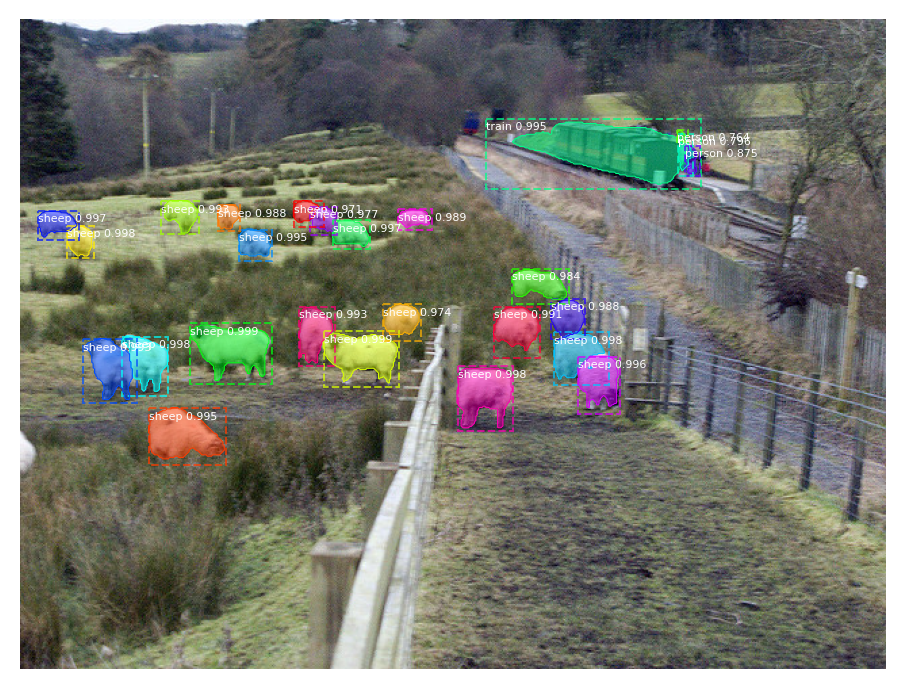

sheep 0.99901366
sheep 0.998879
sheep 0.9982261
sheep 0.9981375
sheep 0.9977549
sheep 0.99763274
sheep 0.99709356
sheep 0.99705434
sheep 0.99623775
sheep 0.99530584
train 0.9945897
sheep 0.9945022
sheep 0.9934643
sheep 0.993317
sheep 0.9930952
sheep 0.9907224
sheep 0.98916525
sheep 0.9877521
sheep 0.9875546
sheep 0.9837961
sheep 0.97734886
sheep 0.9739216
sheep 0.9707373
person 0.875202
person 0.7963446
person 0.7637462


In [7]:
# загрузим следующий файл изображения из указанной директории
file_names = next(os.walk(IMAGE_DIR))[2] 
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# запускаем сегментацию, указываем изображение. 
results = model.detect([image], verbose=1)
r = results[0] # первый, а в нашем случае и единственный элемент списка.
# визуализация
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
c=r['class_ids'] # номера классов
for i in range(len(c)):
  print(class_names[c[i]],r['scores'][i]) # печатаем информацию о найденных объектах

## Сегментация изображений с вебкамеры
Для выполнения этого раздела у вас должна быть установлена вебкамера и в браузере необходимо разрешить ее использование. 

Colab плохо работает в вебкамерой, нам придется воспользоваться специальным языком JavaScript, чтобы дать ему возможность получать информацию с нее. Выполняйте код JS не вникая. 

Для перехвата ошибок будем выполнять этот код в блоке `try/except`.



In [8]:
'''
## Camera Capture
Using a webcam to capture images for processing on the runtime.
Source: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi
'''

from IPython.display import display, Javascript # библиотеки для визуализации и работы с Javascript
from google.colab.output import eval_js # для выполнения Javascript 
from base64 import b64decode # для конвертирования изображения и видео в подходящий формат

# функция для снятия изображения с вебкамеры
def take_photo(filename='photo.jpg', quality=0.8):
  # указываем имя файла, куда будет записано изображение
  # и его "качество".
  
  # этот код на Javascript:
  js = Javascript('''
    async function takePhoto(quality) {
      // функция асинхронная, т.е. выполняется независимо от других
      const div = document.createElement('div');
      // элемент с видео и его атрибуты
      const video = document.createElement('video');
      video.style.display = 'block';
      // захват видео потока с вебкамеры 
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      // показ видео в HTML элементе
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // масштабирование элемента под размер
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // печать информации о процессе
      let jsLog = function(abc) {
        document.querySelector("#output-area").appendChild(document.createTextNode(`${abc}... `));
      }

    
      // ожидаем 10000  милисекунд (10 секунд) пока пользователь наведет камеру 
      await new Promise(resolve => setTimeout(resolve, 10000));
      // и снимаем 5 изображений подряд с нее
      for (let i = 0; i < 5; i++) {
        const canvas = document.createElement('canvas');
        //ширина
        canvas.width = video.videoWidth;
        //высота
        canvas.height = video.videoHeight;
        //захватываем кадр
        canvas.getContext('2d').drawImage(video, 0, 0);
        //в изображение
        img = canvas.toDataURL('image/jpeg', quality);

        jsLog(i + "sending")
        // вызываем функцию python и посылаем ей это изображение
        google.colab.kernel.invokeFunction('notebook.run_algo', [img], {});
        jsLog(i + "SENT")

        // ждем 1000 милисекунд до снятия следующего изображения
        await new Promise(resolve => setTimeout(resolve, 1000));
      }

      stream.getVideoTracks()[0].stop(); // останавливаем видеопоток
    }
    ''')
  # вернулись в python
  display(js) # отображаем HTML в выходной ячейке
  data = eval_js('takePhoto({})'.format(quality)) # вызываем функцию takePhoto() на JavaScript

Имея код на JavaScript для работы с вебкамерой используем его для захвата изображений. 

У вас есть 10 секунд, чтобы навести камеру на нужные объекты (видео будет показано), а затем с нее снимется и сегментируется 5 изображений подряд с интервалом 1 сек. 

In [9]:
# библиотеки для отображения
import IPython
from google.colab import output
from google.colab.patches import cv2_imshow

import time # для работы со временем
import sys # системная
import numpy as np 
import cv2 # обработка изображений и видео

from PIL import Image # для изображений
from io import BytesIO # для работы с байтами
import base64 # для декодирования байтов
import logging # логирование

# функция для конвертации изображения в виде последовательности байтов
# (как это вернула функция JavaScript) в подходящий вид
def data_uri_to_img(uri):
  """convert base64image to numpy array"""
  try:
    # декодируем байты
    image = base64.b64decode(uri.split(',')[1], validate=True)
    # конвертируем в бинарный вид PIL
    image = Image.open(BytesIO(image))
    # конвертируем в numpy array
    image = np.array(image, dtype=np.uint8); 
    return image
  except Exception as e:
    logging.exception(e);print('\n')
    return None

# функция, которая будет вызываться из JavaScript и получать захваченные изображения и сегментировать их
def run_algo(imgB64):
  """
  in Colab, run_algo function gets invoked by the JavaScript, that sends N images every second

  params:
    image: image
  """
  # конвертируем полученное изображение
  image = data_uri_to_img(imgB64)  
  if image is None:
    print("At run_algo(): image is None.")
    return

  try:
    # запускаем сегментацию
    results = model.detect([image], verbose=1)
    # визуализация
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
    c=r['class_ids']
    for i in range(len(c)):
      print(class_names[c[i]],r['scores'][i])
    print('\n')

  except Exception as e:
    logging.exception(e)
    print('\n')

# регистрируем функцию выше, чтобы код JS мог ее вызывать
output.register_callback('notebook.run_algo', run_algo)


In [ ]:
# вызываем эту функцию для захвата и сегментации
take_photo()

Что ж, мои предметы распознались в целом верно ...  

# Задания

Сегментируйте различные изображения, кадры видео. Попробуйте найти объекты которые
- а) не распознаны вообще
- б) распознаны, но не верным классом
- в) распознаны, но неверная маска или ограничивающее окошко

Сделайте сами изображения, в которых объекты частично накладываются и проверьте, как степень перекрытия влияет на сегментацию. 

Если у вас есть кот\собака или сосед по парте, сегментируйте их изображения. 

# Ссылки

Использованы и адаптированы материалы:

https://towardsdatascience.com/webcam-object-detection-with-mask-r-cnn-on-google-colab-b3b012053ed1 


https://github.com/matterport/Mask_RCNN


https://habr.com/ru/post/421299/

https://www.pyimagesearch.com/2018/11/19/mask-r-cnn-with-opencv/ 
